## Tuning analysis for a set of recordings from the same mode

Here, we demonstrate tuning analysis of a set of recordings in several modes. The names of the modes and number of files used in each mode is set in the second code cell. 
The following steps are carried:
- A group of recordings from the set of files listed in the [annotations.json file](https://github.com/MTG/otmm_makam_recognition_dataset ) in the given modes are downloaded as the first step.
- Then pitch analysis and pitch distribution computation is carried
- Tonic annotation is accessed from Dunya and interval distributions are computed (with respect to tonic)
- Octave folding is applied and mean of all distributions are computed
- Automatic peak picking applied to detect scale degrees' distance to the tonic
- Interval list stored in the Scala format (http://www.huygens-fokker.org/scala/) to be able to sonify the intervals using computer keyboard. A Scala file(.scl) is created for each mode in the modes list. 

To be able to download sounds from Dunya, you would need to create a user and obtain an API authenticaion key(token). Please create your user from: http://dunya.compmusic.upf.edu/social/register/ In order to get your API token you have to log in to Dunya, access your profile, you will find your token there. 

In [1]:
#This is cell is for imports and initialization
import os 
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from compmusic.dunya import docserver as ds
from compmusic import dunya as dn
from external_utilities.predominantmelodymakam import PredominantMelodyMakam
from external_utilities.pitchdistribution import PitchDistribution
from scipy.spatial import distance

from compmusic import dunya
token = '...yourTokenGoesHere...'#you should put your Dunya token here 
dn.set_token(token)#setting the token

%matplotlib inline
CENTS_IN_OCTAVE=1200
REF_PITCH=220

### Downloading the recordings with mode 'Huseyni'

In [2]:
fileType='mp3'
numFiles=15
collectionName='makam'
modeType='makam'
modes=['Huseyni','Saba','Huzzam']#Setting list of modes for which we will estimate a scale
dataDir='../data/compMusicDatasets/turkishMakam/'

#Load dataset files in mode Huseyni
with open(dataDir+'annotations.json') as json_data:
    collectionFiles = json.load(json_data)

#Create directories for modes and download one recording for each
modeFilesInfo={}
print('Downloading mp3 files in ',dataDir)
for mode in modes:
    if not os.path.exists(dataDir+mode):
        os.mkdir(dataDir+mode)
    mbidList=[]
    tonics={}
    fileCnt=0
    for file in collectionFiles:
        if(file[modeType]==mode):
            mbid=file['mbid'].split('http://musicbrainz.org/recording/')[-1]
            
            #collection-specific access to tonic info
            if collectionName=='makam':
                content = ds.file_for_document(mbid,'audioanalysis','tonic')
                tonic = json.loads(content.decode())['value']
            elif collectionName=='carnatic' or collectionName=='hindustani':
                content = ds.file_for_document(mbid,'ctonic','tonic')
                tonic = content.decode()
            
            #If tonic info is available from Dunya, add to set of recordings
            if tonic == None:
                print('Tonic could not be read for ',mbid,', skipping this file')
            else:
                tonics[mbid]=float(tonic)
                mbidList.append(mbid)
                #Download mp3
                name = mbid+'.'+fileType
                mp3FileURI = os.path.join(dataDir+mode,name)
                #Download file if it has not been previously downloaded
                if not os.path.exists(mp3FileURI):
                    contents=ds.file_for_document(mbid, fileType)
                    open(mp3FileURI, "wb").write(contents)
                fileCnt+=1
                if fileCnt>=numFiles:
                    print(numFiles, ' files downloaded')
                    break
    modeFilesInfo[mode]=(mbidList,tonics)
    
print('Download finished!')

15  files downloaded
15  files downloaded
15  files downloaded
Download finished!


### Pitch extraction and distribution computation

In [3]:
def tonicAlgndOctWrppdDstrs(mode,mbidList,tonics,pd_params,numBins,dataDir):
    '''Gathering tonic aligned octave wrapped distributions 
    
    Args:
        mode (str): name of the mode ('Huseyni', 'Saba', etc)
        mbidList (list): list of musicbrainz ids
        tonics (dict): dictionary mapping mbids to tonic info in Hz
        numBins (int): number of bins in octave for the distribution
        dataDir (str): path info
    Outputs:
        pcds (numpy array(2D)): 2D array(pd size * number of file) 
            containing pitch distribution for each file   
    '''
    pcds=np.array([]).reshape(0,numBins)
    #Pitch extractor definition
    extractor = PredominantMelodyMakam(filter_pitch=True)
    print('Pitch analysis of files in mode ', mode)

    for mbid in mbidList:
        name = mbid+'.'+fileType
        mp3FileURI = os.path.join(dataDir+mode,name)
        #Setting file names for writing analysis results
        pitchFile=dataDir+mode+'/'+mbid+'.pitch'
        histFile=dataDir+mode+'/'+mbid+'.pitch_hist.json'

        #If pitch file exists, read it, if not run extractor and create the pitch file
        if not os.path.exists(pitchFile):
            #running pitch extraction 
            results = extractor.run(mp3FileURI)
            pitch = results['settings']  # collapse the keys in settings
            pitch['pitch'] = results['pitch']
            #Writing pitch data to text file, 
            # you can use it together with SonicVisualizer to view in sync with the spectrogram of the mp3 file
            pitchSeriesHz=[]
            file = open(pitchFile,'w')
            for p_triplet in pitch['pitch']:
                file.write(str(p_triplet[0])+'\t'+str(p_triplet[1])+'\n')
                pitchSeriesHz.append(p_triplet[1])
            file.close()
            pitchSeriesHz=np.array(pitchSeriesHz)
        else:
            pitchData = np.loadtxt(pitchFile)
            timeStamps=pitchData[:,0]
            pitchSeriesHz=pitchData[:,1]

        #Pitch distribution computation
        #Computing pitch distribution with default reference frequency = REF_PITCH
        pitch_distribution = PitchDistribution.from_hz_pitch(pitchSeriesHz,REF_PITCH, **pd_params)
        pitch_distribution.to_json(histFile)

        #Computing pitch distribution with reference frequency = tonic
        tonic_Hz=tonics[mbid]
        pitch_distribution_tonicRef = PitchDistribution.from_hz_pitch(pitchSeriesHz,tonic_Hz, **pd_params)
        pitch_distribution_tonicRef.to_json(histFile.replace('.pitch_hist.json','.pitch_hist_wrtTonic.json'))

        #Creating octave folded distribution
        pcd=np.zeros(numBins)#initializing pitch class distribution
        for index_pd in range(len(pitch_distribution_tonicRef.bins)):
            bin_pd=pitch_distribution_tonicRef.bins[index_pd]#get bin in pitch distribution
            index_pcd=np.mod(bin_pd,CENTS_IN_OCTAVE)/pd_params['step_size']#corresponding index in pitch class distribution
            pcd[index_pcd]+=pitch_distribution_tonicRef.vals[index_pd]
        pcds = np.vstack((pcds,pcd))

    return pcds


In [4]:
#Running extraction and gathering of data
pd_params={'kernel_width': 5, 'step_size': 5}#pitch distribution extractor parameters in cents
bins=np.linspace(0, CENTS_IN_OCTAVE, CENTS_IN_OCTAVE/pd_params['step_size'], endpoint=False)#distribution bins for octave-folded histogram
numBins=len(bins)

#Gathering tonic aligned, octave wrapped distributions for each mode
modePcds={}
for mode in modes:
    (mbidList,tonics)=modeFilesInfo[mode]
    pcds=tonicAlgndOctWrppdDstrs(mode,mbidList,tonics,pd_params,numBins,dataDir)
    modePcds[mode]=pcds

print('Pitch files are stored in ',dataDir)
print('You can use Sonic Visualizer at this step to check pitch extraction quality')

Pitch analysis of files in mode  Huseyni


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Pitch analysis of files in mode  Saba
Pitch analysis of files in mode  Huzzam
Pitch files are stored in  ../data/compMusicDatasets/turkishMakam/
You can use Sonic Visualizer at this step to check pitch extraction quality


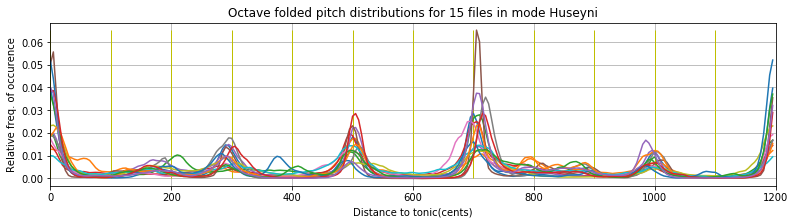

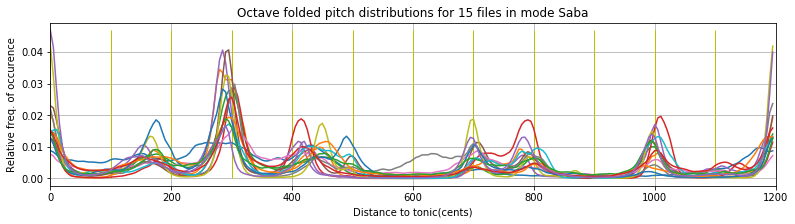

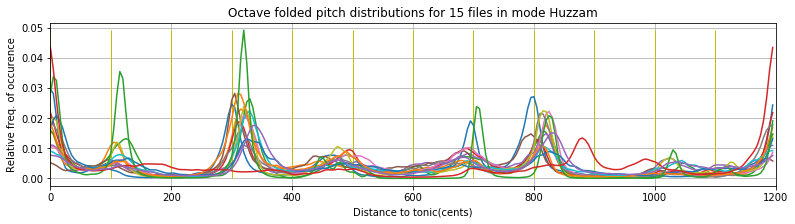

In [5]:
#Plotting all distributions
for mode in modes:
    pcds=modePcds[mode]
    plt.figure(figsize=(13, 3))
    for pcd in pcds:
        plt.plot(bins,pcd)

    plt.title('Octave folded pitch distributions for '+str(len(pcds))+' files in mode '+mode)
    plt.xlim([0,1200])
    plt.grid()
    ticks=np.arange(0,1200,100)
    plt.vlines(ticks, 0, np.max(pcds), color='y',lw=1)
    plt.ylabel('Relative freq. of occurence')
    plt.xlabel('Distance to tonic(cents)')

### Plotting average distribution and extracting scale information

In [6]:
#Function definition for automatic scale-interval detection from pitch distribution
def peakLocationDetection(pcd):
    '''A simple peak detection implementation for demonstration purposes
    Thresholds are manually set for this demo
    '''
    windowSize=15#should be odd
    midPointIndex=int(windowSize/2)
    threshold=np.max(pcd)*0.05
    peakIndexes=[]
    for index in range(len(pcd)-windowSize):
        frame=pcd[index:index+windowSize]
        if (np.argmax(frame)==midPointIndex) and np.max(frame)>threshold:
            peakIndexes.append(index+midPointIndex)
    return peakIndexes

Intervals computed:  [175 295 500 705 790 880 995] (cents with respect to tonic)
Intervals computed:  [ 170  295  420  700  790 1000] (cents with respect to tonic)
Intervals computed:  [ 115  320  475  700  815 1030] (cents with respect to tonic)


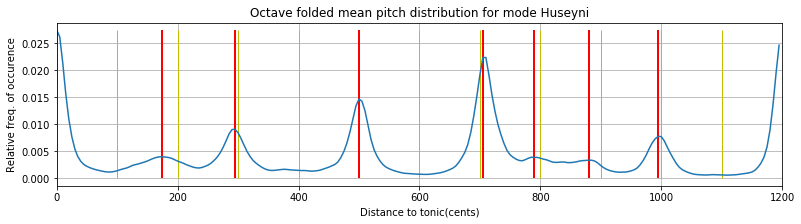

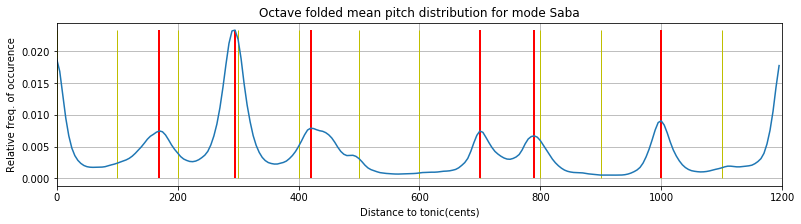

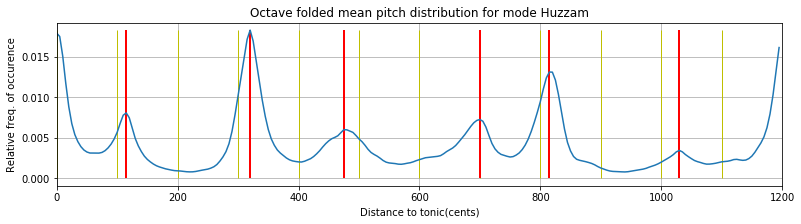

In [7]:
#Extracting intervals and plotting together with mean distributions
modeIntervals={}
for mode in modes:
    pcds=modePcds[mode]
    
    pcds_array=np.array(pcds)
    mean_pcd=np.mean(pcds, axis=0)

    plt.figure(figsize=(13, 3))
    ticks=np.arange(0,1200,100)
    plt.vlines(ticks, 0, max(mean_pcd), color='y',lw=1)
    plt.plot(bins,mean_pcd)

    plt.title('Octave folded mean pitch distribution for mode '+mode)
    plt.xlim([0,1200])
    plt.grid()
    plt.ylabel('Relative freq. of occurence')
    plt.xlabel('Distance to tonic(cents)')

    #Detect intervals from pitch distribution and plot them on the figure
    intervals=np.array(peakLocationDetection(mean_pcd))*pd_params['step_size']
    plt.vlines(intervals, 0, max(mean_pcd), color='r',lw=2)
    print('Intervals computed: ',intervals, '(cents with respect to tonic)')
    modeIntervals[mode]=intervals

### Creating the Scala file
Writing the scale to .scl file which can be loaded in Scala with which one can sonify the estimated scale 

In [8]:
for mode in modes:
    intervals=modeIntervals[mode]
    scalaFile=dataDir+mode+'_scale.scl'
    file = open(scalaFile,'w')
    file.write('! autopeak.scl\n!\nFile created by tuningAnalysis\n'+str(len(intervals)+1)+'\n!\n')
    #First octave
    for interval in intervals:
        file.write(str(float(interval))+'\n')
    file.write(str(float(CENTS_IN_OCTAVE))+'\n')#octave
    file.close()

### Loading the estimated scales in Scala
Initiate a synthesizer your Scala software can communicate with for synthesis (for example simplesynth). Open Scala and click 'Open' to choose the .scl file this code has created in your local folder: 'mode'_scale.scl. A scl file is created for each mode.

Scala would display the set of pitches of the loaded scale as a list and set the keyboard layout to start the scale with C. If you would like to set tonic to some other note and frequency, click 'Opts.' on the top menu. You can set the tonic frequency('frequency for 1/1') and the offset (deafult is C.0)

Now you can click 'Play' on the top menu to start experiment with your new keyboard playing the scale automatically extracted by the analysis above. Enjoy!